In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt 

###########################################
# 1. LOAD CSV AND PREPARE THE DATA
###########################################

Number of playlists: 471
Number of tracks: 28356
Total nodes: 28827
Number of edges: 32833
Number of track features: 12
Track feature columns: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


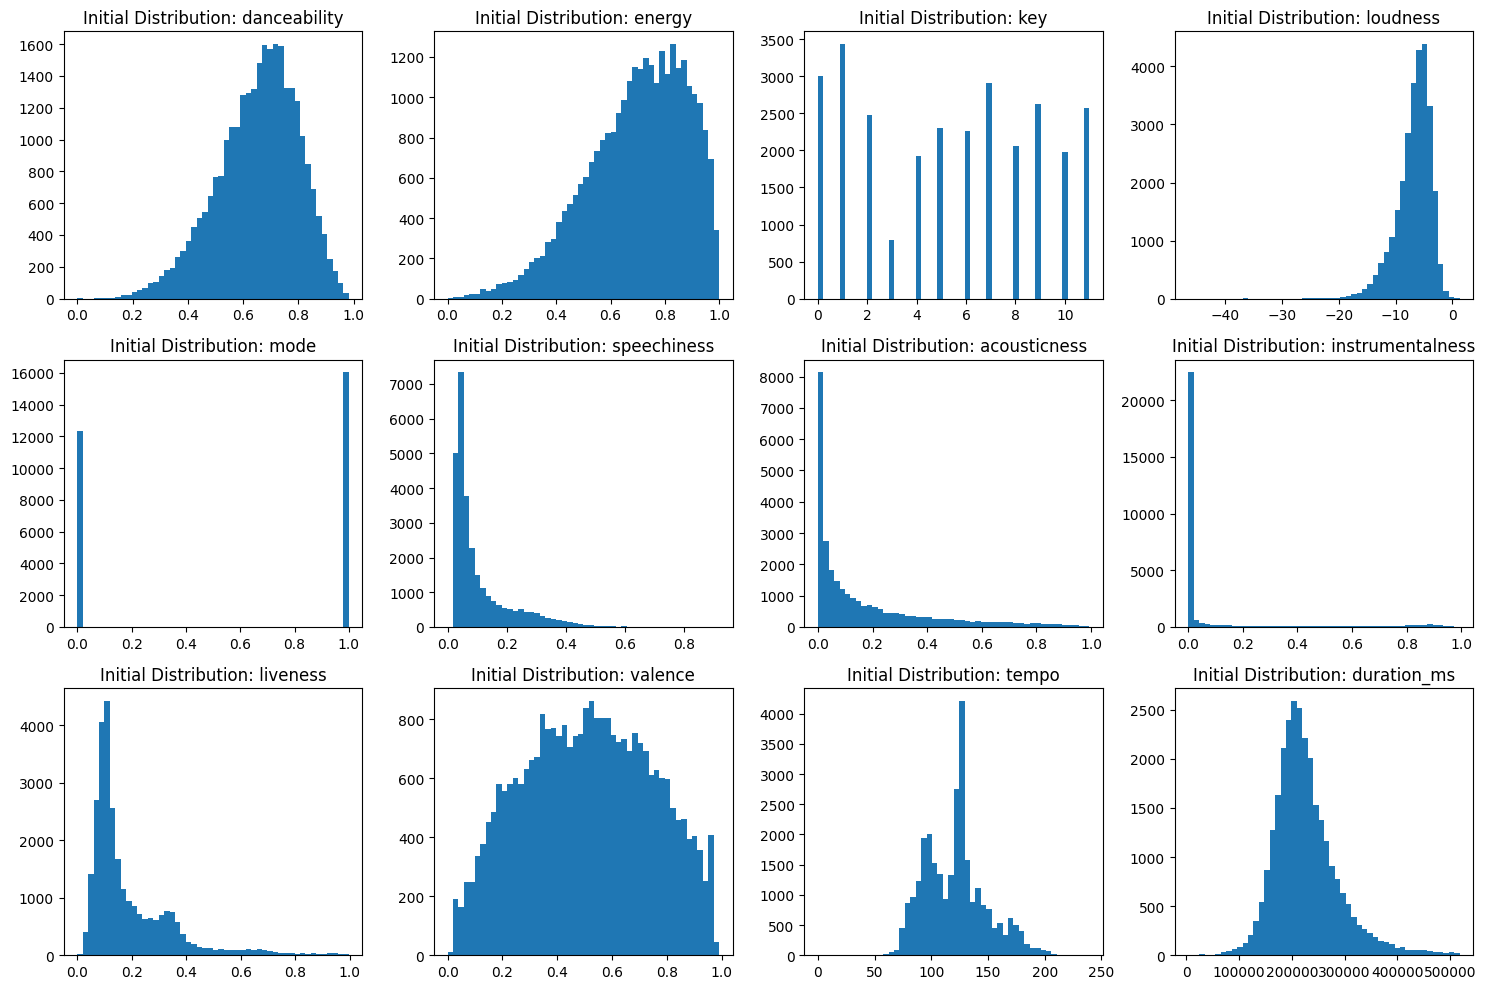

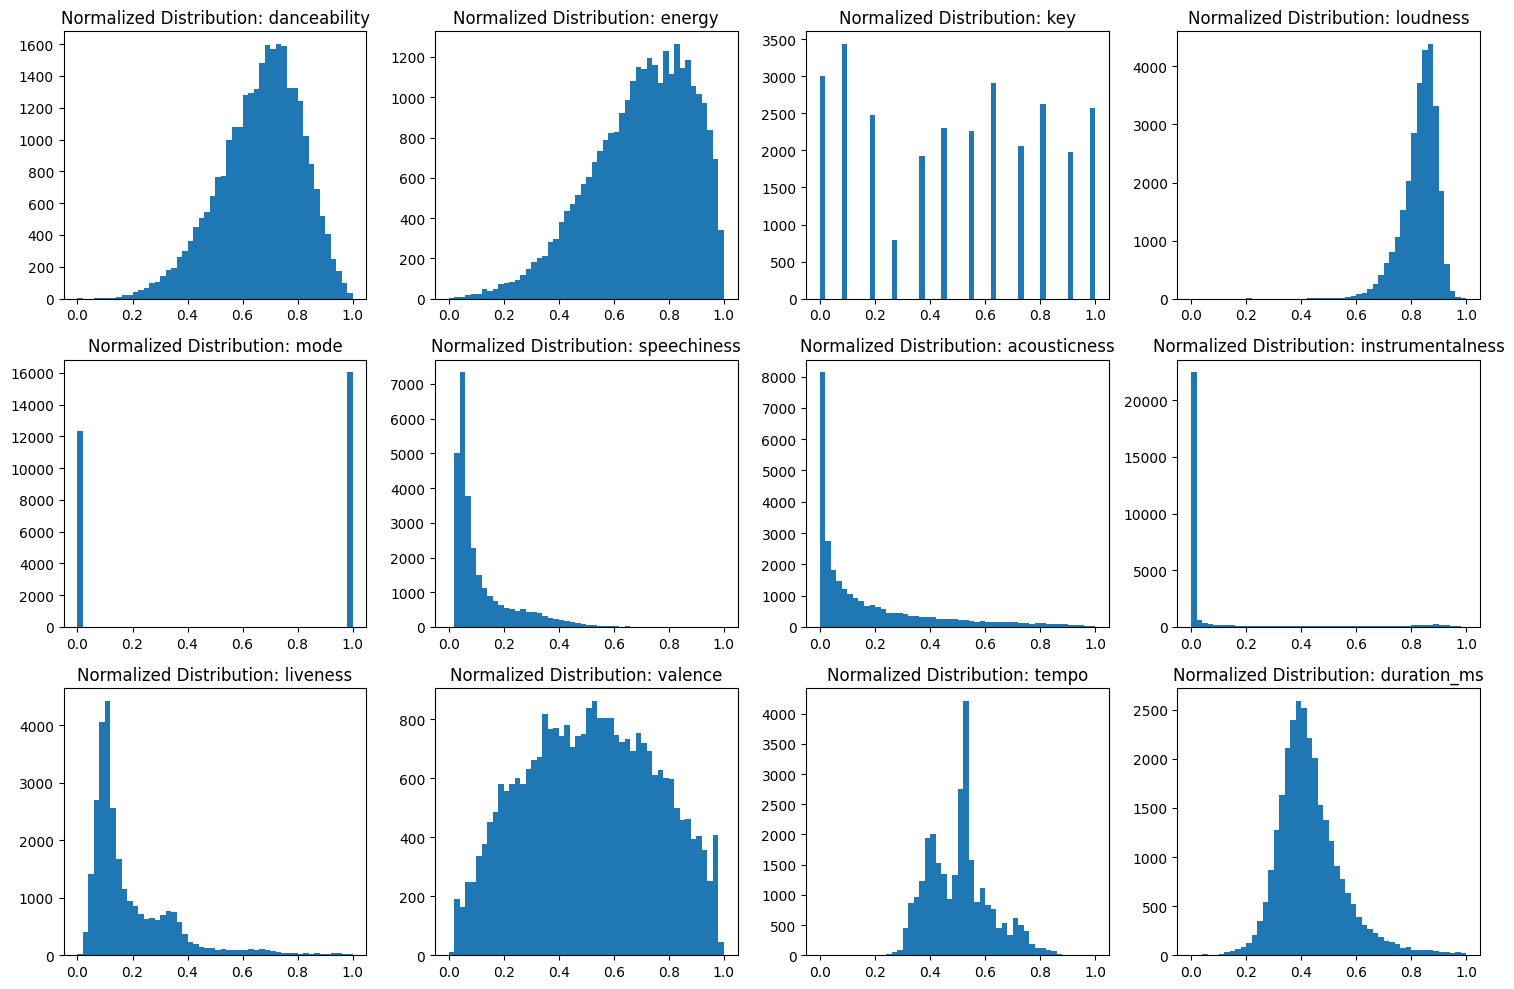

Graph built: 28827 nodes (471 playlists, 28356 tracks), 32833 undirected edges.


In [2]:
# Change this path to your actual CSV file.
csv_path = "spotify_songs.csv"
df = pd.read_csv(csv_path)

# --- Build Unique Node Sets ---
# Use playlists as one node set and tracks as the other.
playlist_ids = df["playlist_id"].unique()
track_ids = df["track_id"].unique()

num_playlists = len(playlist_ids)
num_tracks = len(track_ids)
total_nodes = num_playlists + num_tracks

print(f"Number of playlists: {num_playlists}")
print(f"Number of tracks: {num_tracks}")
print(f"Total nodes: {total_nodes}")

# Create mapping dictionaries:
# For playlists: assign indices 0 to num_playlists-1.
playlist_id_to_index = {pid: i for i, pid in enumerate(playlist_ids)}
# For tracks: assign indices num_playlists to total_nodes-1.
track_id_to_index = {tid: i + num_playlists for i, tid in enumerate(track_ids)}

# --- Build Graph Edges ---
# Each row in the CSV is an occurrence of a track in a playlist.
source_nodes = []  # playlist nodes (indices)
target_nodes = []  # track nodes (indices)
for _, row in df.iterrows():
    pid = row["playlist_id"]
    tid = row["track_id"]
    if pid in playlist_id_to_index and tid in track_id_to_index:
        source_nodes.append(playlist_id_to_index[pid])
        target_nodes.append(track_id_to_index[tid])

# For an undirected graph, add both directions.
edge_index = torch.tensor(
    [source_nodes + target_nodes, target_nodes + source_nodes], dtype=torch.long
)

num_edges = edge_index.shape[1] // 2 # Undirected edges
print(f"Number of edges: {num_edges}")

# --- Create Node Features ---
# We choose a set of audio feature columns for the track nodes.
track_feature_cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]
num_features = len(track_feature_cols)

print(f"Number of track features: {num_features}")
print(f"Track feature columns: {track_feature_cols}")


# Instead of initializing playlists with zeros, we initialize with random vectors.
playlist_features = torch.randn((num_playlists, num_features), dtype=torch.float)

# Build a DataFrame of unique tracks (first occurrence per track) and set its index.
track_df = df.drop_duplicates("track_id").set_index("track_id")

# Initialize track feature matrix.
track_features = torch.zeros((num_tracks, num_features), dtype=torch.float)
track_list = []  # for keeping order of track IDs
for tid in track_ids:
    track_list.append(tid)
    if tid in track_df.index:
        # Get features as floats; if conversion fails, use zeros.
        try:
            feats = [float(track_df.loc[tid][col]) for col in track_feature_cols]
        except Exception as e:
            feats = [0.0] * num_features
        track_features[track_ids.tolist().index(tid)] = torch.tensor(
            feats, dtype=torch.float
        )
    else:
        track_features[track_ids.tolist().index(tid)] = torch.zeros(num_features)

# Plot histograms of initial track features before normalization
plt.figure(figsize=(15, 10))
for i, col_name in enumerate(track_feature_cols):
    plt.subplot(3, 4, i+1) # 3 rows, 4 columns of subplots
    plt.hist(track_features[:, i].numpy(), bins=50)
    plt.title(f'Initial Distribution: {col_name}')
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()


# OPTIONAL: Normalize track features (min-max scaling)
min_vals = track_features.min(dim=0)[0]
max_vals = track_features.max(dim=0)[0]
# To avoid division by zero:
range_vals = max_vals - min_vals
range_vals[range_vals == 0] = 1.0
track_features = (track_features - min_vals) / range_vals

# Plot histograms of normalized track features
plt.figure(figsize=(15, 10))
for i, col_name in enumerate(track_feature_cols):
    plt.subplot(3, 4, i+1) # 3 rows, 4 columns of subplots
    plt.hist(track_features[:, i].numpy(), bins=50)
    plt.title(f'Normalized Distribution: {col_name}')
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()


# Concatenate playlist and track features to create node features.
x = torch.cat([playlist_features, track_features], dim=0)

# Create the PyG Data object.
data = Data(x=x, edge_index=edge_index)

print(
    f"Graph built: {total_nodes} nodes ({num_playlists} playlists, {num_tracks} tracks), "
    f"{edge_index.shape[1]//2} undirected edges."
)

###########################################
# 2. DEFINE THE GNN MODEL
###########################################

In [3]:
class GNNRec(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNRec, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.conv2(x, edge_index)
        return x


in_channels = num_features
hidden_channels = 128
out_channels = 64
learning_rate = 0.01
num_epochs = 1000


model = GNNRec(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###########################################
# 3. TRAIN THE GNN
###########################################

Epoch 10/1000 - Loss: 1.3638
Epoch 20/1000 - Loss: 1.3622
Epoch 30/1000 - Loss: 1.3413
Epoch 40/1000 - Loss: 1.2844
Epoch 50/1000 - Loss: 1.2522
Epoch 60/1000 - Loss: 1.2217
Epoch 70/1000 - Loss: 1.1686
Epoch 80/1000 - Loss: 1.1329
Epoch 90/1000 - Loss: 1.0799
Epoch 100/1000 - Loss: 1.0512
Epoch 110/1000 - Loss: 1.0158
Epoch 120/1000 - Loss: 0.9645
Epoch 130/1000 - Loss: 0.9242
Epoch 140/1000 - Loss: 0.8878
Epoch 150/1000 - Loss: 0.8794
Epoch 160/1000 - Loss: 0.8420
Epoch 170/1000 - Loss: 0.8287
Epoch 180/1000 - Loss: 0.7921
Epoch 190/1000 - Loss: 0.7883
Epoch 200/1000 - Loss: 0.7836
Epoch 210/1000 - Loss: 0.7576
Epoch 220/1000 - Loss: 0.7467
Epoch 230/1000 - Loss: 0.7214
Epoch 240/1000 - Loss: 0.7252
Epoch 250/1000 - Loss: 0.7036
Epoch 260/1000 - Loss: 0.6883
Epoch 270/1000 - Loss: 0.6726
Epoch 280/1000 - Loss: 0.6675
Epoch 290/1000 - Loss: 0.6554
Epoch 300/1000 - Loss: 0.6543
Epoch 310/1000 - Loss: 0.6568
Epoch 320/1000 - Loss: 0.6437
Epoch 330/1000 - Loss: 0.6317
Epoch 340/1000 - Lo

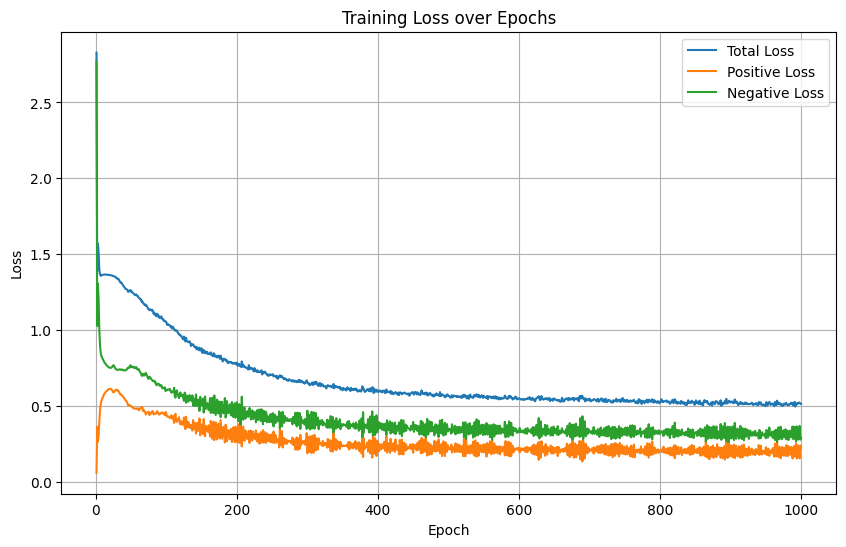

In [4]:
# Prepare positive edges (only one direction is used for training)
pos_playlist_nodes = torch.tensor(source_nodes, dtype=torch.long)
pos_track_nodes = torch.tensor(target_nodes, dtype=torch.long)
num_pos_edges = pos_playlist_nodes.shape[0]

# Lists to store loss values for plotting
loss_history = []
pos_loss_history = []
neg_loss_history = []
epochs_list = []


model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index)

    # Compute positive scores (dot product between playlist and track embeddings)
    pos_playlist_emb = embeddings[pos_playlist_nodes]
    pos_track_emb = embeddings[pos_track_nodes]
    pos_scores = (pos_playlist_emb * pos_track_emb).sum(dim=1)
    pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-15).mean()

    # Negative sampling: sample random playlist-track pairs.
    neg_playlist_nodes = torch.randint(0, num_playlists, (num_pos_edges,))
    neg_track_nodes = torch.randint(num_playlists, total_nodes, (num_pos_edges,))
    neg_playlist_emb = embeddings[neg_playlist_nodes]
    neg_track_emb = embeddings[neg_track_nodes]
    neg_scores = (neg_playlist_emb * neg_track_emb).sum(dim=1)
    neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-15).mean()

    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()

    # Store loss values for plotting
    loss_history.append(loss.item())
    pos_loss_history.append(pos_loss.item())
    neg_loss_history.append(neg_loss.item())
    epochs_list.append(epoch + 1) # Epoch number for x-axis

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, loss_history, label='Total Loss')
plt.plot(epochs_list, pos_loss_history, label='Positive Loss')
plt.plot(epochs_list, neg_loss_history, label='Negative Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


###########################################
# 4. INTERACTIVE RECOMMENDATION
###########################################

In [5]:
# Switch to evaluation mode and compute final embeddings.
model.eval()
with torch.no_grad():
    final_embeddings = model(data.x, data.edge_index)

# Separate playlist and track embeddings.
playlist_embeddings = final_embeddings[:num_playlists]  # indices 0 .. num_playlists-1
track_embeddings = final_embeddings[
    num_playlists:
]  # indices num_playlists .. total_nodes-1

# Build an inverse mapping from track node index (global index) to track_id.
inv_track_map = {v: k for k, v in track_id_to_index.items()}

track_df_reset = df.drop_duplicates("track_id").set_index("track_id").reset_index()

def get_track_node_index_by_name(query_name):
    """
    Given a song name, return (track_id, global_node_index) if found.
    The search is case-insensitive and expects an exact match.
    """
    matches = track_df_reset[track_df_reset["track_name"].str.lower() == query_name.lower()] # Use reset index df
    if matches.empty:
        return None, None
    else:
        track_id = matches['track_id'].iloc[0] # Get track_id from the first row of matches
        node_index = track_id_to_index.get(track_id)
        return track_id, node_index


def get_recommendations_for_song(query_name, topk=10):
    """
    Returns top-k song recommendations for a given song name.
    """
    track_id, node_index = get_track_node_index_by_name(query_name)
    if node_index is None:
        return f"Song '{query_name}' not found. Please try again."

    # Retrieve the embedding of the query song.
    song_embedding = final_embeddings[node_index]

    # Compute cosine similarities between the query song and all track embeddings.
    # (Using cosine similarity can help mitigate scale differences.)
    # Normalize embeddings for cosine similarity.
    song_norm = song_embedding / song_embedding.norm(p=2)
    track_norms = F.normalize(track_embeddings, p=2, dim=1)
    similarities = torch.matmul(track_norms, song_norm)

    # Exclude the query song from recommendations.
    local_index = node_index - num_playlists
    if 0 <= local_index < similarities.shape[0]:
        similarities[local_index] = -float("inf")

    # Get the top-k recommended track indices (local indices in track_embeddings).
    top_sim_values, top_indices = torch.topk(similarities, topk)

    recommended_track_names = []
    for local_idx in top_indices.tolist():
        global_node_idx = (
            local_idx + num_playlists
        )  # convert local index to global index
        rec_track_id = inv_track_map.get(global_node_idx, None)
        if rec_track_id is not None:
            rec_track_name = track_df.loc[rec_track_id]["track_name"]
            recommended_track_names.append(rec_track_name)
        else:
            recommended_track_names.append("Unknown Track")

    return recommended_track_names


print("\n--- Interactive Song Recommendation ---")
print(
    "Type a song name (exactly as in the dataset) to get 10 similar song recommendations."
)
print("Type 'quit' to exit.\n")

while True:
    query_name = input("Enter a song name: ").strip()
    if query_name.lower() == "quit":
        print("Exiting recommendation system.")
        break

    recommended_track_names = get_recommendations_for_song(query_name)

    if isinstance(recommended_track_names, str): # Error message returned
        print(recommended_track_names + "\n") # Print the error message
        continue # Go to next iteration of the loop

    print(f"\nTop 10 recommended songs similar to '{query_name}':")
    for i, name in enumerate(recommended_track_names, 1):
        print(f"{i}. {name}")
    print("\n")


--- Interactive Song Recommendation ---
Type a song name (exactly as in the dataset) to get 10 similar song recommendations.
Type 'quit' to exit.




Top 10 recommended songs similar to 'closer':
1. Hold On
2. Photograph
3. Only You
4. Wannabe
5. I Don't Know
6. The Rest Will Follow
7. Thinkin Bout You
8. Unbelievable
9. Bleed
10. Too Close


Exiting recommendation system.
